# USER INPUTS

In [1]:
# e- mesh + ray-trace file loads
directory_to_load_ne_npy = '/net/eofe-data005/psfclab001/lansing/docs/ray-tracing/COBRA/OblShock-3/'
directory_to_load_ray_trace_npy = directory_to_load_ne_npy + 'runs/OblShock-TID120ns-NP16x1e6-62548184/'
tid = 120  # ns
Np = int(16e6)  # number of rays in laser beam
x_beam_width, z_beam_height = 10, 18  # mm, full-width and full-height of rect laser beam
beam_x_offset, beam_z_offset = 15, 0  # mm, how much the circular beam is shifted in +x/+z directions (to fall on top of the crocodile target)

# first collecting lens params (https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=6277)
D = 1  # inches, diameter of the first collecting lens
f = 150  # mm, focal length of the lens
y_imagining_plane = 10  # mm, the desired y=? (y-plane) to image
d = 10  # inches, distance from y=0 to lens

# camera sensor + synthetic shadowgraph params
dx_bin_um = 50  # um (microns), assumed pixel resolution on image sensor
vmin_shadow, vmax_shadow = 0, 600  # counts-per-pixel, sets vmin=black and vmax=white on the 'gray' colorscale


# import python modules and files

In [2]:
# 
import matplotlib.pyplot as plt
import numpy as np
#import scipy.constants as sc

#
import sys
sys.path.insert(0, directory_to_load_ne_npy)
#import particle_tracker as pt
import ray_transfer_matrix as rtm

# 
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
from matplotlib.colors import LogNorm


# constants / useful conversion factors

In [3]:
# 
m_per_nm = 1e-9
cm3_per_m3 = 1e6
m3_per_cm3 = 1/cm3_per_m3
m_per_mm = 1e-3
mm_per_m = 1/m_per_mm
m_per_cm = 1e-2
num_degs = 360
num_rads = 2 * np.pi
deg_per_rad = num_degs / num_rads
m_per_um = 1e-6
um_per_m = 1 / m_per_um
rad_per_mrad = 1e-3
mrad_per_rad = 1 / rad_per_mrad
mm_per_inch = 25.4
#c = sc.c

# 
x_beam_width *= m_per_mm/2  # half-width
z_beam_height *= m_per_mm/2  # half-height
beam_size = np.array( [x_beam_width, z_beam_height] )  # half-widths and half-heights
beam_x_offset *= m_per_mm
beam_z_offset *= m_per_mm


# load all saved .npy files

In [4]:
# 
ne_npy_str_name = f"{tid}ns_3D_ne_per_m3.npy"
sxyz0_npy_str_name = f"3D_sxyz0_tid{tid}ns_Np{Np}.npy"  # (3, Np), (x0, y0, z0) starting positions for all initialized rays
rf_npy_str_name = f"3D_rf_tid{tid}ns_Np{Np}.npy"  # (4, Np), (x, theta_x, z, phi_z) ending positions for all traced rays

## load rays
s0 = np.load(f"{directory_to_load_ray_trace_npy}{sxyz0_npy_str_name}")
rf = np.load(f"{directory_to_load_ray_trace_npy}{rf_npy_str_name}")

## load e- density mesh
ne_m3_tid = np.load(f'{directory_to_load_ne_npy}{ne_npy_str_name}')  # m^-3
num_x_pts, num_y_pts, num_z_pts = ne_m3_tid.shape  # our convention (y is probe direction, z is axial height)
#print(num_x_pts, num_y_pts, num_z_pts)  # (800, 800, 420)

# transition to ray-tracer x/y/z coordinate convention
#ne_m3_tid = np.swapaxes(ne_m3_tid, 1, 2)  # swaps y and z axes
#num_x_pts, num_y_pts, num_z_pts = ne_m3_tid.shape  # ray-tracer convention (z is probe direction, y is axial height)
#print(num_x_pts, num_y_pts, num_z_pts)  # (800, 420, 800)

# volume cubes with dx = dy = dz = 5e-5 m
dx_m = 50 * m_per_um  # m
# pts * dx ---> (x = 40 mm, y = 40 mm, z = 21 mm)
extent_z_m = num_z_pts * dx_m / 2  # m, half-length in z
extent_y_m = num_y_pts * dx_m / 2  # m, half-length in y
extent_x_m = num_x_pts * dx_m / 2  # m, half-length in x
#print(extent_x_m * mm_per_m, extent_y_m * mm_per_m, extent_z_m * mm_per_m)  # (20, 20, 10.5) mm

# construct the spatial grid in x (array to array), y (axial direction / height), and z (along the reconnection layer, the "probing direction" in ray-tracer code land)
zs_edges_m = np.linspace(-extent_z_m, extent_z_m, num_z_pts + 1)  # m, array of z edge spatial locations
ys_edges_m = np.linspace(-extent_y_m, extent_y_m, num_y_pts + 1)  # m, array of y edge spatial locations
xs_edges_m = np.linspace(-extent_x_m, extent_x_m, num_x_pts + 1)  # m, array of x edge spatial locations
#print(xs_edges_m[0:5] * mm_per_m, xs_edges_m[395:405] * mm_per_m)  # ([-20.   -19.95 -19.9  -19.85 -19.8 ] [-0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15  0.2 ])

# get center spatial locations from the grid edges
zs_m = (zs_edges_m[1:] + zs_edges_m[:-1]) / 2  # m, array of z center spatial locations
ys_m = (ys_edges_m[1:] + ys_edges_m[:-1]) / 2  # m, array of y center spatial locations
xs_m = (xs_edges_m[1:] + xs_edges_m[:-1]) / 2  # m, array of x center spatial locations


# n_e plot (central slices)

z[400] = 0.0250 mm
y[210] = 0.0250 mm


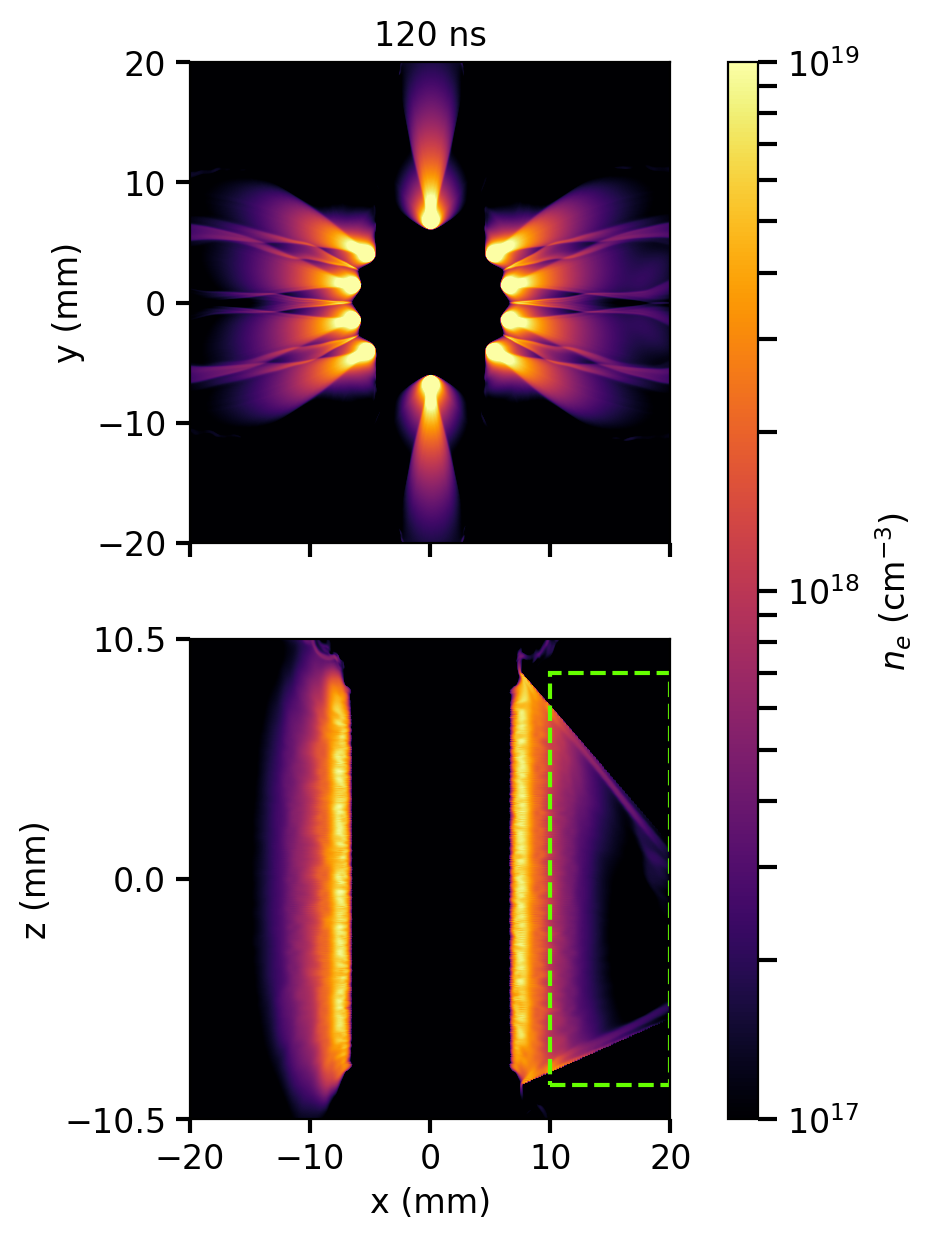

In [5]:
# params
# 
vmin = 1e17
vmax = 1e19  # 1e19
# 
figsize_x, figsize_y = 5, 7
# 
laser_lw = 1.5
# 
aspect_xy = 1  # 0.15  # 0.2
new_aspect = aspect_xy * (2 * extent_y_m) / (2 * extent_x_m)  # aspect_xy * 44 / 2.5 = same
aspect_xz = new_aspect / ( (2 * extent_z_m) / (2 * extent_x_m) )  # aspect_xz / (18 / 2.5) = same
# 
fs_ticks = 12  # 40
fs_xy = 12  # 50
fs_title = 12  # 50
# 
tickwidth, ticklength = 1.5, 5
# 
y_idx = int( num_y_pts / 2 )  # iterate over y indices (the axial / height direction)
print(f"z[{y_idx}] = {ys_m[y_idx] * mm_per_m:.4f} mm")
# 
z_idx = int( num_z_pts / 2 )  # iterate over z indices (the reconnection layer direction) (1760 data points from -44 mm to +44 mm)
print(f"y[{z_idx}] = {zs_m[z_idx] * mm_per_m:.4f} mm")
# 
start, end = -extent_x_m * mm_per_m, extent_x_m * mm_per_m  # ax.get_xlim()
dx = 10  # mm
xticks = np.arange(start, end + dx/2, dx)
# 
start, end = -extent_z_m * mm_per_m, extent_z_m * mm_per_m
dz = 10.5
zticks = np.arange(start, end + dz/2, dz)


# LSH: added plot of test slab
fig, axs = plt.subplots(2, 1, figsize=(figsize_x,figsize_y), dpi = 200, sharex = True, facecolor = 'white', gridspec_kw = {'wspace':0., 'hspace':0.2})  # (9,11)


######################################################################################################################################


# 
ax = axs[0]
# 
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fs_ticks)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(fs_xy)
for item in ([ax.title]):
    item.set_fontsize(fs_title)
# LSH: "The first two dimensions (M, N) of X define the rows and columns of the image."
# X = gorgon_struct.ne[:,y_idx,:].T * m3_per_cm3
im = ax.imshow(X = ne_m3_tid[:,:,z_idx].T * m3_per_cm3, cmap= 'inferno', extent = (-extent_x_m*mm_per_m, extent_x_m*mm_per_m, -extent_y_m*mm_per_m, extent_y_m*mm_per_m), norm = LogNorm(vmin=vmin, vmax=vmax), aspect=aspect_xy, origin="lower")  # clim = [0, 1e25], vmin, vmax
#ax_xy.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.xaxis.set_tick_params(width=tickwidth, length=ticklength)  # labelrotation=90
ax.yaxis.set_tick_params(width=tickwidth, length=ticklength)
ax.set_xlim((-extent_x_m * mm_per_m, extent_x_m * mm_per_m))  # (-10, 10)
ax.set_ylim((-extent_y_m * mm_per_m, extent_y_m * mm_per_m))  # (-44, 44)
ax.set_facecolor(plt.get_cmap('inferno')(0))
# https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis
ax.xaxis.set_ticks(xticks)
ax.yaxis.set_ticks(xticks)
ax.set_title(f"{tid} ns", fontsize = fs_title)


# 
ax = axs[1]  # ax_xz
# 
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fs_ticks)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(fs_xy)
for item in ([ax.title]):
    item.set_fontsize(fs_title)
# LSH: "The first two dimensions (M, N) of X define the rows and columns of the image."
# X = gorgon_struct.ne[:,y_idx,:].T * m3_per_cm3
im = ax.imshow(X = ne_m3_tid[:,y_idx,:].T * m3_per_cm3, cmap= 'inferno', extent = (-extent_x_m*mm_per_m, extent_x_m*mm_per_m, -extent_z_m*mm_per_m, extent_z_m*mm_per_m), norm = LogNorm(vmin=vmin, vmax=vmax), aspect=aspect_xz, origin="lower")  # clim = [0, 1e25], vmin, vmax
ax.set_xlabel("x (mm)")
ax.set_ylabel("z (mm)")
ax.xaxis.set_tick_params(width=tickwidth, length=ticklength)  # labelrotation=90
ax.yaxis.set_tick_params(width=tickwidth, length=ticklength)
ax.set_xlim((-extent_x_m * mm_per_m, extent_x_m * mm_per_m))  # (-10, 10)
ax.set_ylim((-extent_z_m * mm_per_m, extent_z_m * mm_per_m))  # (-10, 10)
ax.set_facecolor(plt.get_cmap('inferno')(0))
# https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis
ax.xaxis.set_ticks(xticks)
ax.yaxis.set_ticks(zticks)
'''
# circ_beam laser outline
entrance_beam = plt.Circle((beam_x_offset * mm_per_m, 0), (beam_diameter / 2) * mm_per_m, color = '#65ff00', ls='--', fill=False, lw=laser_lw)  # color = 'r'
ax.add_patch(entrance_beam)
'''
# rect_beam laser outline
dxbeam_offset, dzbeam_offset = 0, 0  # 0.04 * x_beam_width_m * mm_per_m
xy_anchor = (-x_beam_width * mm_per_m + beam_x_offset * mm_per_m + dxbeam_offset, -z_beam_height * mm_per_m + beam_z_offset * mm_per_m + dzbeam_offset)
entrance_beam = plt.Rectangle(xy_anchor, 2 * x_beam_width * mm_per_m - 2 * dxbeam_offset, 2 * z_beam_height * mm_per_m - 2 * dzbeam_offset, color = '#65ff00', ls='--', fill=False, lw=laser_lw)  # color = 'r'
ax.add_patch(entrance_beam)


######################################################################################################################################


# 
ytop_tif = axs[0].get_position().y1
ybot_tif = axs[1].get_position().y0
height_tif = ytop_tif - ybot_tif
# 
cb_tickwidth, cb_ticklength = 1.5, 7
cb_frac, cb_pad, cb_aspect = 0.01, 0.025, 40
# 
#fig.subplots_adjust(right=0.95)
# 
cbar_ax = fig.add_axes([0.81, ybot_tif, 0.03, height_tif])  # left, bottom, width, height  # [0.97, 0.382, 0.025, 0.567]
cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction = cb_frac, pad = cb_pad, aspect = cb_aspect)  # cax=cax, 
cb.ax.tick_params(length=cb_ticklength, width=cb_tickwidth, which="major")  # labelsize=40,
cb.ax.tick_params(length=cb_ticklength, width=cb_tickwidth, which="minor")  # labelsize=40,
cb.ax.tick_params(labelsize=fs_xy)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_label(label='$n_e$ (cm$^{-3}$)', size=fs_title, labelpad=5)  # weight='bold'

# 
#plt.savefig(f"/home/lansing/docs/ray-tracing/3D-marz-shadowgraphs/ne_meshes_Zexptime.png", dpi=600, bbox_inches='tight')
plt.show()


# use particle_tracker.py functions for ray-tracing

# RTM analysis (for "focused" shadowgraphy)

In [6]:
'''
# TEST
print('r0')
x_temp, z_temp = self.r0[0, 0:5], self.r0[2, 0:5]
for x, z in zip(x_temp, z_temp):
    print( f"({x}, {z})" )
'''

# 
class Shadowgraphy3(rtm.Rays):
    def solve(self):
                
        '''
        rtm.distance(r, d)
            - 4x4 matrix for traveling a distance d
            - *** see 2023.07-22.94 GoodNotes, 6 July 2023 / 13 July 2023 ***
            - r = r0, (4 x N) = ( [x_mm, theta_rad, z_mm, phi_rad] x N )
            - d = travel distance from end of plasma region, to the first optic; focal_plane = 0 means at the exit face of the e- cube (what we want, probably)
        '''
        r1=rtm.distance(r = self.r0, d = self.L - self.focal_plane) #displace rays to lens. Accounts for object with depth

        # special mod to move rays back to the left (-x), only undoing this b/c lens is centered at x=z=0
        #r1_mod = r1.copy()
        r1[0,:] -= beam_x_offset * mm_per_m
        r1[2,:] -= beam_z_offset * mm_per_m
        
        '''
        rtm.circular_aperture(r, R):
            - Filters rays to find those inside a radius R
            - r = r1 (the rays already priorly transported over a free space from the edge of the plasma to the first optic), (4 x N)
            - R = radius of the lens (physical size of the optic)
            # filt = r[0,:]**2+r[2,:]**2 > R**2
            # filt = x^2 + y^2 > R^2 (those rays with spatial locations beyond the circular radius of the lens); these rays become "None" and are no longer tracked (b/c they are lost)
        '''
        r2=rtm.circular_aperture(r = r1, R = self.R) # cut off
        
        # special mod to move rays back to the right (+x)
        r2[0,:] += beam_x_offset * mm_per_m
        r2[2,:] += beam_z_offset * mm_per_m
        
        
        '''
        rtm.sym_lens(r, f):
            - helper function to create an axisymmetryic lens (b/c f1 = f2 = f, the two orthogonal axes have the same focal length)
            # return lens(r, f,f)
            - r = r2 (the rays that were transported over free space from plasma edge to the first optic, and the rays that are still within the radius of this first optic)
            - f = L/2 (focal length of the first lens, f1 = f2 = f (axisymmetric); this must be the "special" focal length for a two-lens telescope?)
        rtm.lens(r, f1, f2):
            - 4x4 matrix for a thin lens, focal lengths f1 and f2 in orthogonal axes
            - *** see 2023.07-22.94 GoodNotes, 14 July 2023 ***
            - l1, l2 = the RTMs for the two axes of the lens
            - https://en.wikipedia.org/wiki/Focal_length
        '''
        r3=rtm.sym_lens(r = r2, f = f) #lens 1

        '''
            - d = travel distance from second optic to CCD ("Charge Coupled Device" is a highly sensitive photon detector) (d = L, for a two-lens telescope?)
        '''
        r4=rtm.distance(r = r3, d = (1/f - 1/self.L)**(-1)) #displace rays to detector
        
        '''
            - rf = (4xN float array): N rays, [x, theta, y, phi], all transported from the r0 at the input
        '''
        self.rf = r4


In [7]:
########################################################

# y-imaging-plane-mm = y-mesh-edge-mm - focal_plane
focal_plane = extent_y_m * mm_per_m - y_imagining_plane  # mm, "focused" shadowgraphy, focal_plane > 0 to decrease y-mm imaging plane (from y=20mm mesh edge), focal_plane < 0 to increase y-mm imaging plane (from y=20mm mesh edge)
# 
D *= mm_per_inch  # mm, diameter of the first collecting lens
# 
u = d * mm_per_inch - extent_y_m * mm_per_m  # mm, length from plasma edge (object) to 1st optic (lens)
# 
dx_bin_m = dx_bin_um * m_per_um  # m, assumed pixel resolution on image sensor

# 
theta_max = np.arctan( (D / 2) / (u) )  # rad, maximum (est) angle from plasma edge to the optic that still falls w/in the lens
v = (1/f - 1/u)**(-1)  # mm, length from 1st optic (lens) to image plane formation (image)
M = v/u  # in-chamber magnification of the image
M_eff = M * 1  # effective overall magnification = M_eff = M * M_extra-optics = M * 1
object2image_mm = u + v  # distance from object to image
# 
x_FOV_sensor_mm = x_beam_width * 2 * mm_per_m * M_eff
z_FOV_sensor_mm = z_beam_height * 2 * mm_per_m * M_eff
FOV_sensor_mm = np.max([x_FOV_sensor_mm, z_FOV_sensor_mm])  # mm, FOV/size of the camera imaging sensor
# 
FOV_plasma_mm = FOV_sensor_mm / M_eff  # mm, length of the plasma that can be imaged to fit onto the SEGOI camera sensor
Lx, Ly = (x_FOV_sensor_mm) / 2, z_FOV_sensor_mm / 2  # mm, width and height of the "CCD detector" (but this is not accounting for 1/8 out-of-chamber magnification); "8 mm diameter FOV on SEGOI camera" (but shadowgraphy camera is different, so . . . parameters?)
#R_sch = 0.1  # mm (?), radius of Schlieren stop/aperture
# 
#print(f"lens #{lens_num}")
print(f"D = {D} mm")
print(f"f = {f} mm")
print(f"u = {u:.1f} mm")
print(f"focal_plane = {focal_plane:.1f} mm")
print('')
print(f"v = {v:.1f} mm")
print(f"M = v/u = {M:.2f}")
print(f"M_eff = M * 1 = {M_eff:.2f}")
print(f"object-to-image = u + v = {object2image_mm:.1f} mm")
print('')
print(f"physical \"sensor\" (at v = {v:.1f} mm) size = (full-width, full-height) = ({2 * Lx:.0f}, {2 * Ly:.0f}) mm")
print(f"plasma full-FOV ~ {FOV_plasma_mm:.1f} mm")  # SEGOI sensor size is 1 cm = 10 mm
print(f"theta_max = {theta_max * mrad_per_rad:.2f} mrad")

# 
sh_lens = Shadowgraphy3(r0 = rf, focal_plane = focal_plane, L=u, R=D/2, Lx=Lx, Ly=Ly, f=f)
sh_lens.solve()

# target goals
# theta_max ~ 60-70 mrad (D and u)
# u >~ 400 mm (limit, can't get too close, and influences M (through v))
# plasma FOV ~ 6-7 mm (M = v/u)

########################################################

D = 25.4 mm
f = 150 mm
u = 234.0 mm
focal_plane = 10.0 mm

v = 417.9 mm
M = v/u = 1.79
M_eff = M * 1 = 1.79
object-to-image = u + v = 651.9 mm

physical "sensor" (at v = 417.9 mm) size = (full-width, full-height) = (18, 32) mm
plasma full-FOV ~ 18.0 mm
theta_max = 54.22 mrad


# plot s0 (where rays begin), rf (where rays end, at edge of 3D e- mesh after tracing), and "focused" shadowgraph (desired y = ? mm plane)

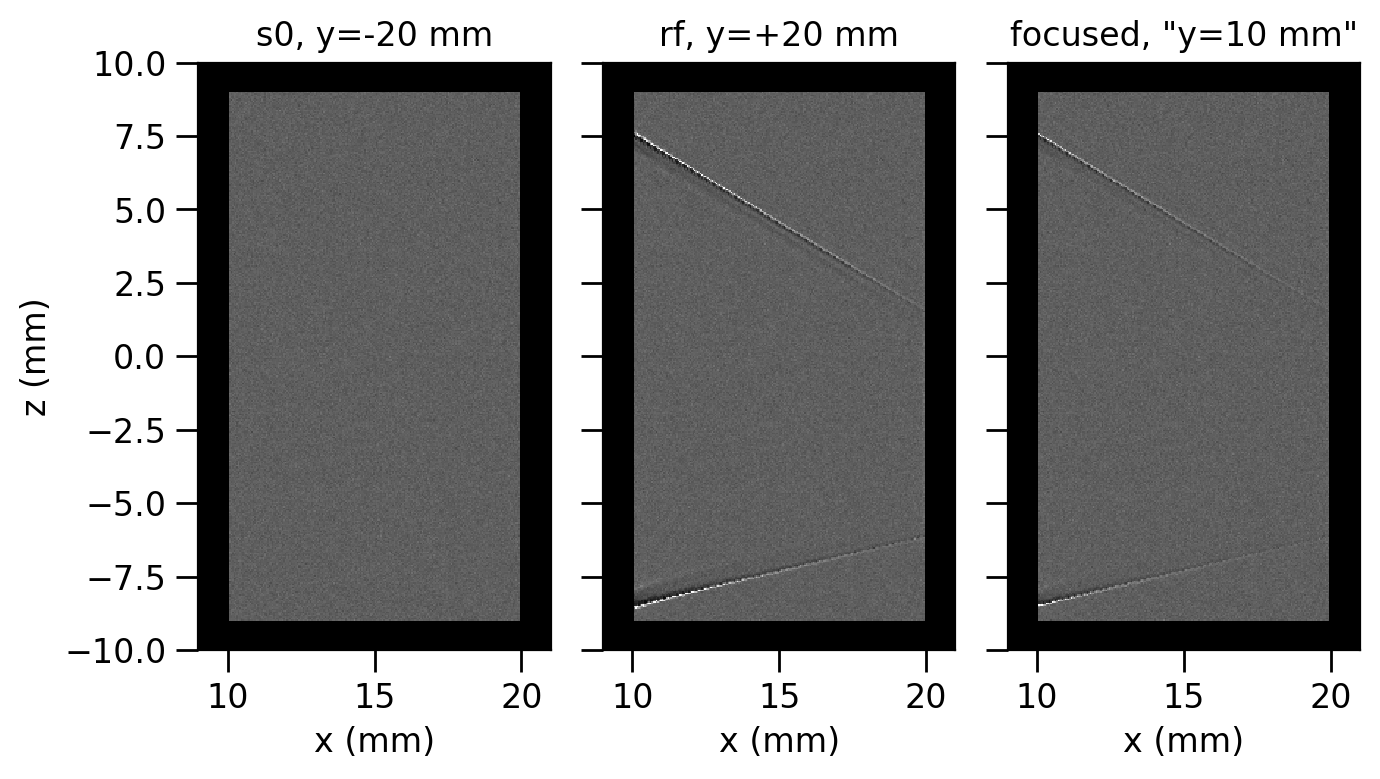

In [8]:
# 
# s0 (m)
# rf (m)
rf_shadow = sh_lens.rf  # sh_lens.rf (mm)

# fonts, formatting
fs_cb = 12  # 33  # 25 # 12
fs_label = 12  # 42  # 30 # 15
fs_ticks = 12  # 38  # 25 # 12
fs_xy = 12
tickwidth, ticklength = 1, 8
#dx_bin_m = 50 * m_per_um  # 50 * m_per_um  # m, assumed pixel resolution on image sensor
i_x, i_z = 0, 2
#nbins_ang = 301
#vmin, vmax, dray = 0, 600, 50
laser_lw = 1.
ax_view_extra_mm = 1  # mm
cmap = 'gray'
plasma_FOV_int_mm = np.floor(FOV_plasma_mm) / 2  # mm

# rectangular image sensor FOV
# x_max_mm, z_max_mm = np.nanmax( abs(rf_shadow[i_x,:]) ), np.nanmax( abs(rf_shadow[i_z,:]) )
#xedges_mm = np.concatenate( (np.arange(0., -(extent_x_m + dx_bin_m/2) * mm_per_m, -dx_bin_m * mm_per_m)[::-1], np.arange(0., (extent_x_m + dx_bin_m/2) * mm_per_m, dx_bin_m * mm_per_m)[1::]) )  # * mm_per_m
#zedges_mm = np.concatenate((np.arange(0., -(extent_y_m + dx_bin_m/2) * mm_per_m, -dx_bin_m * mm_per_m)[::-1], np.arange(0., (extent_y_m + dx_bin_m/2) * mm_per_m, dx_bin_m * mm_per_m)[1::]))  # * mm_per_m
# coordinates in plasma coordinates (backprop image sensor dimensions into plasma coordinates based on M)
x_max_mm, z_max_mm = Lx / M, Ly / M
xedges_mm = beam_x_offset * mm_per_m + np.concatenate( (np.arange(0., -x_max_mm, -dx_bin_m * mm_per_m)[::-1], np.arange(0., x_max_mm, dx_bin_m * mm_per_m)[1::]) )  # * mm_per_m
zedges_mm = beam_z_offset * mm_per_m + np.concatenate((np.arange(0., -z_max_mm, -dx_bin_m * mm_per_m)[::-1], np.arange(0., z_max_mm, dx_bin_m * mm_per_m)[1::]))  # * mm_per_m
X, Z = np.meshgrid(xedges_mm, zedges_mm)

'''
start, end = -plasma_FOV_int_mm, plasma_FOV_int_mm  # ax.get_xlim()
dz = 7  # mm
zticks = np.arange(start, end + dz/2, dz)
xticks = zticks + beam_x_offset * mm_per_m
'''

### Plot
fig, axs = plt.subplots(1, 3, figsize=(7,4), dpi = 200, facecolor = 'white', sharey = True, sharex = False)


# 
ax = axs[0]
H, _, _ = np.histogram2d( s0[0,:] * mm_per_m, s0[1,:] * mm_per_m, bins=(xedges_mm, zedges_mm) )
ax.pcolormesh(X, Z, H.T, cmap=cmap, vmin=vmin_shadow, vmax=vmax_shadow, shading='auto')
ax.set_xlabel("x (mm)", fontsize = fs_label)
ax.set_ylabel("z (mm)", fontsize = fs_label)
ax.set_xlim((-x_max_mm - ax_view_extra_mm + beam_x_offset * mm_per_m, x_max_mm + ax_view_extra_mm + beam_x_offset * mm_per_m))
ax.set_ylim((-z_max_mm - ax_view_extra_mm, z_max_mm + ax_view_extra_mm))
ax.set_aspect('equal')
# 
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fs_ticks)
# 
#ax.xaxis.set_ticks(xticks)
#ax.set_xticklabels(["-0.3", "0", "0.3"])
#ax.yaxis.set_ticks(yticks)
# 
ax.xaxis.set_tick_params(width=tickwidth, length=ticklength)  # labelrotation=90
ax.yaxis.set_tick_params(width=tickwidth, length=ticklength)
#cb.ax.tick_params(length=5, width=1.25, which="minor")  # labelsize=40,
# 
ax.set_title(f"s0, y=-{extent_y_m * mm_per_m:.0f} mm", fontsize = fs_label)
# 
ax.set_facecolor(plt.get_cmap('gray')(0))  # ax.set_facecolor('black')
# 
#ax.xaxis.set_ticks(xticks)
#ax.yaxis.set_ticks(zticks)


# 
ax = axs[1]
H, _, _ = np.histogram2d( rf[i_x,:] * mm_per_m, rf[i_z,:] * mm_per_m, bins=(xedges_mm, zedges_mm) )
ax.pcolormesh(X, Z, H.T, cmap=cmap, vmin=vmin_shadow, vmax=vmax_shadow, shading='auto')
ax.set_xlabel("x (mm)", fontsize = fs_label)
#ax.set_ylabel("$z$ (mm)", fontsize = fs_label)
ax.set_xlim((-x_max_mm - ax_view_extra_mm + beam_x_offset * mm_per_m, x_max_mm + ax_view_extra_mm + beam_x_offset * mm_per_m))
ax.set_ylim((-z_max_mm - ax_view_extra_mm, z_max_mm + ax_view_extra_mm))
ax.set_aspect('equal')
# 
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fs_ticks)
# 
#ax.xaxis.set_ticks(xticks)
#ax.set_xticklabels(["-0.3", "0", "0.3"])
#ax.yaxis.set_ticks(yticks)
# 
ax.xaxis.set_tick_params(width=tickwidth, length=ticklength)  # labelrotation=90
ax.yaxis.set_tick_params(width=tickwidth, length=ticklength)
#cb.ax.tick_params(length=5, width=1.25, which="minor")  # labelsize=40,
# 
ax.set_title(f"rf, y=+{extent_y_m * mm_per_m:.0f} mm", fontsize = fs_label)
# 
ax.set_facecolor(plt.get_cmap('gray')(0))  # ax.set_facecolor('black')
# 
#ax.xaxis.set_ticks(xticks)
#ax.yaxis.set_ticks(zticks)


# 
ax = axs[2]
H, _, _ = np.histogram2d( -rf_shadow[i_x,:] / M, -rf_shadow[i_z,:] / M, bins=(xedges_mm, zedges_mm) )
ax.pcolormesh(X, Z, H.T, cmap=cmap, vmin=vmin_shadow, vmax=vmax_shadow, shading='auto')
ax.set_xlabel("x (mm)", fontsize = fs_label)
#ax.set_ylabel("$z$ (mm)", fontsize = fs_label)
ax.set_xlim((-x_max_mm - ax_view_extra_mm + beam_x_offset * mm_per_m, x_max_mm + ax_view_extra_mm + beam_x_offset * mm_per_m))
ax.set_ylim((-z_max_mm - ax_view_extra_mm, z_max_mm + ax_view_extra_mm))
ax.set_aspect('equal')
# 
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fs_ticks)
# 
#ax.xaxis.set_ticks(xticks)
#ax.set_xticklabels(["-0.3", "0", "0.3"])
#ax.yaxis.set_ticks(yticks)
# 
ax.xaxis.set_tick_params(width=tickwidth, length=ticklength)  # labelrotation=90
ax.yaxis.set_tick_params(width=tickwidth, length=ticklength)
#cb.ax.tick_params(length=5, width=1.25, which="minor")  # labelsize=40,
# 
ax.set_title(f'focused, "y={extent_y_m * mm_per_m - focal_plane:.0f} mm"', fontsize = fs_label)
# 
ax.set_facecolor(plt.get_cmap('gray')(0))  # ax.set_facecolor('black')
# 
#ax.xaxis.set_ticks(xticks)
#ax.yaxis.set_ticks(zticks)


# 
fig.tight_layout()

'''
# 
cb_tickwidth, cb_ticklength = 1, 5
cb_frac, cb_pad, cb_aspect = 0.05, 0.025, 40
# 
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.18, 0.02, 0.693])  # 0.9125  # left, bottom, width, height  # [0.835, 0.0475, 0.0375, 0.9425]
cb = fig.colorbar(im5, cax=cbar_ax, orientation='vertical', fraction = cb_frac, pad = cb_pad, aspect = cb_aspect)  # cax=cax, 
cb.ax.tick_params(length=cb_ticklength, width=cb_tickwidth, which="major")  # labelsize=40,
#cb.ax.tick_params(length=0.6 * cb_ticklength, width=0.8 * cb_tickwidth, which="minor")  # labelsize=40,
for t in cb.ax.get_yticklabels():
     t.set_fontsize(fs_title)
cb.set_label(label=f'#/pix', size=fs_title)  # weight='bold'
'''

# 
#plt.savefig(f"/home/lansing/docs/ray-tracing/3D-marz-shadowgraphs/ray-dists_Zexptime.png", dpi=600, bbox_inches='tight')
plt.show()


In [9]:
raise SystemExit(0)

SystemExit: 0

/home/software/anaconda3/2021.11/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# 16 July (Lansing edit of Shadowgraphy1)
class Shadowgraphy2(rtm.Rays):  # rtm.Rays has r0, focal_plane = 0, L=400, R=25, Lx=18, Ly=13.5
    def solve(self):
        ## 2 lens telescope, M = 1
        
        
        '''
        rtm.distance(r, d)
            - 4x4 matrix for traveling a distance d
            - *** see 2023.07-22.94 GoodNotes, 6 July 2023 / 13 July 2023 ***
            - r = r0, (4 x N) = ( [x_mm, theta_rad, y_mm, phi_rad] x N )
            - d = travel distance from end of plasma region, to the first optic; focal_plane = 0 means at the exit face of the e- cube (what we want, probably)
        '''
        r1=rtm.distance(r = self.r0, d = self.L - self.focal_plane) #displace rays to lens. Accounts for object with depth
        
        
        '''
        rtm.circular_aperture(r, R):
            - Filters rays to find those inside a radius R
            - r = r1 (the rays already priorly transported over a free space from the edge of the plasma to the first optic), (4 x N)
            - R = radius of the lens (physical size of the optic)
            # filt = r[0,:]**2+r[2,:]**2 > R**2
            # filt = x^2 + y^2 > R^2 (those rays with spatial locations beyond the circular radius of the lens); these rays become "None" and are no longer tracked (b/c they are lost)
        '''
        r2=rtm.circular_aperture(r = r1, R = self.R) # cut off
        
        
        '''
        rtm.sym_lens(r, f):
            - helper function to create an axisymmetryic lens (b/c f1 = f2 = f, the two orthogonal axes have the same focal length)
            # return lens(r, f,f)
            - r = r2 (the rays that were transported over free space from plasma edge to the first optic, and the rays that are still within the radius of this first optic)
            - f = L/2 (focal length of the first lens, f1 = f2 = f (axisymmetric); this must be the "special" focal length for a two-lens telescope?)
        rtm.lens(r, f1, f2):
            - 4x4 matrix for a thin lens, focal lengths f1 and f2 in orthogonal axes
            - *** see 2023.07-22.94 GoodNotes, 14 July 2023 ***
            - l1, l2 = the RTMs for the two axes of the lens
            - https://en.wikipedia.org/wiki/Focal_length
        '''
        r3=rtm.sym_lens(r = r2, f = f) #lens 1

        '''
            - d = travel distance from second optic to CCD ("Charge Coupled Device" is a highly sensitive photon detector) (d = L, for a two-lens telescope?)
        '''
        r4=rtm.distance(r = r3, d = (1/f - 1/self.L)**(-1)) #displace rays to detector
        
        '''
            - rf = (4xN float array): N rays, [x, theta, y, phi], all transported from the r0 at the input
        '''
        self.rf = r4
